# TDA@YSDA
## Seminar 6

In the following we consider examples from

A Topology Layer for Machine Learning  
Brüel-Gabrielsson et al. _International Conference on Artificial Intelligence and Statistics (2020)_


https://github.com/bruel-gabrielsson/TopologyLayer.

In [1]:
!pip install git+https://github.com/bruel-gabrielsson/TopologyLayer.git

  Cloning https://github.com/bruel-gabrielsson/TopologyLayer.git to /private/var/folders/29/7zhc2w2n7jn0l4p1tyzskm3w0000gn/T/pip-req-build-e1mqwxid
  Running command git clone --filter=blob:none --quiet https://github.com/bruel-gabrielsson/TopologyLayer.git /private/var/folders/29/7zhc2w2n7jn0l4p1tyzskm3w0000gn/T/pip-req-build-e1mqwxid
  Resolved https://github.com/bruel-gabrielsson/TopologyLayer.git to commit 309f49dfde8ccf8e771b3546917552e704048b6b
  Preparing metadata (setup.py) ... done


In [2]:
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn as nn
from topologylayer.nn import AlphaLayer, BarcodePolyFeature
from topologylayer.nn import LevelSetLayer2D, SumBarcodeLengths, PartialSumBarcodeLengths

### Point cloud optimization

In [3]:
# random pointcloud
data = np.random.rand(100, 2)

In [4]:
# optimization to increase size of holes
layer = AlphaLayer(maxdim=1)
x = torch.autograd.Variable(torch.tensor(data).type(torch.float), requires_grad=True)
f1 = BarcodePolyFeature(1,2,0)
optimizer = torch.optim.Adam([x], lr=1e-2)
for i in range(100):
    optimizer.zero_grad()
    loss = -f1(layer(x))
    loss.backward()
    optimizer.step()
    
x = x.detach().numpy()

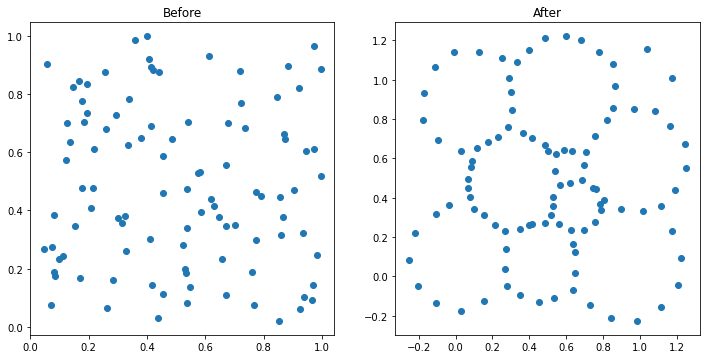

In [5]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 5.75))
ax[0].set_title("Before")
ax[1].set_title("After")
ax[0].scatter(data[:,0], data[:,1])
ax[1].scatter(x[:,0], x[:,1])
plt.show()

### Level set optimization

In [6]:
class TopLoss(nn.Module):
    def __init__(self, size):
        super(TopLoss, self).__init__()
        self.pdfn = LevelSetLayer2D(size=size,  sublevel=False)
        self.topfn = PartialSumBarcodeLengths(dim=1, skip=1) # penalize more than 1 hole
        self.topfn2 = SumBarcodeLengths(dim=0) # penalize more than 1 max

    def forward(self, beta):
        dgminfo = self.pdfn(beta)
        return self.topfn(dgminfo) + self.topfn2(dgminfo)

In [7]:
# generate circle on grid
n = 50
def circlefn(i, j, n):
    r = np.sqrt((i - n/2.)**2 + (j - n/2.)**2)
    return np.exp(-(r - n/3.)**2/(n*2))


def gen_circle(n):
    beta = np.empty((n,n))
    for i in range(n):
        for j in range(n):
            beta[i,j] = circlefn(i,j,n)
    return beta

beta = gen_circle(n)

In [8]:
m = 1500
X = np.random.randn(m, n**2)
y = X.dot(beta.flatten()) + 0.05*np.random.randn(m)
beta_ols = (np.linalg.lstsq(X, y, rcond=None)[0]).reshape(n,n)

In [9]:
tloss = TopLoss((50,50)) # topology penalty
dloss = nn.MSELoss() # data loss

beta_t = torch.autograd.Variable(torch.tensor(beta_ols).type(torch.float), requires_grad=True)
X_t = torch.tensor(X, dtype=torch.float, requires_grad=False)
y_t = torch.tensor(y, dtype=torch.float, requires_grad=False)
optimizer = torch.optim.Adam([beta_t], lr=1e-2)
for i in range(500):
    optimizer.zero_grad()
    tlossi = tloss(beta_t)
    dlossi = dloss(y_t, torch.matmul(X_t, beta_t.view(-1)))
    loss = 0.1*tlossi + dlossi
    loss.backward()
    optimizer.step()
    if (i % 10 == 0):
        print(i, tlossi.item(), dlossi.item())
        
beta_est = beta_t.detach().numpy()

0 219.22679138183594 4.1642002346353735e-11
10 129.88441467285156 1.596432089805603
20 89.59905242919922 1.5592046976089478
30 65.85884857177734 1.4432882070541382
40 51.23305892944336 1.3054931163787842
50 40.45665740966797 1.1529181003570557
60 31.719860076904297 1.0871657133102417
70 25.275596618652344 1.0224381685256958
80 20.66962432861328 0.9398082494735718
90 17.140344619750977 0.8638011813163757
100 14.303855895996094 0.8058464527130127
110 12.047727584838867 0.7548894882202148
120 10.325979232788086 0.6870687007904053
130 8.837949752807617 0.6374648809432983
140 7.772507190704346 0.5789512395858765
150 6.602433204650879 0.5389947295188904
160 5.7558183670043945 0.4961809515953064
170 5.093158721923828 0.44792601466178894
180 4.507623672485352 0.4125632345676422
190 3.944215774536133 0.37776461243629456
200 3.538059711456299 0.3493664562702179
210 3.187688112258911 0.3211296498775482
220 2.880506992340088 0.300344854593277
230 2.594393730163574 0.2759217619895935
240 2.37917566

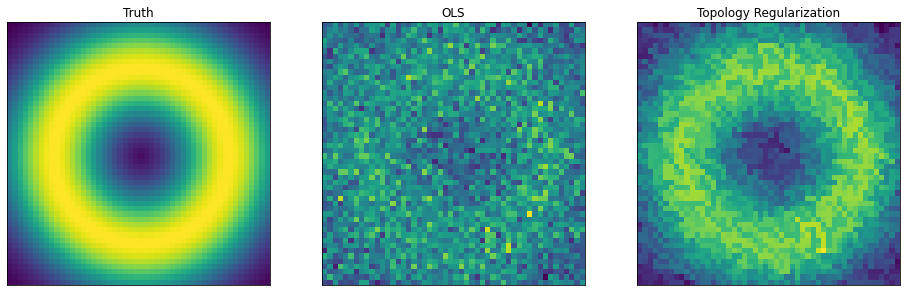

In [10]:
fig, ax = plt.subplots(ncols=3, figsize=(16,5))
ax[0].imshow(beta)
ax[0].set_title("Truth")
ax[1].imshow(beta_ols)
ax[1].set_title("OLS")
ax[2].imshow(beta_est)
ax[2].set_title("Topology Regularization")
for i in range(3):
    ax[i].set_yticklabels([])
    ax[i].set_xticklabels([])
    ax[i].tick_params(bottom=False, left=False)

### Quantifying point clouds (2 points)

#### Geometry score

Consider sklearn `digits` dataset. Consider a dimensionality reduction method of your choice - PCA, Isomap, autoencoder to reduce the dimensionality of data to the lower-dimensional space. Compute and plot the $\mathrm{RLT}^1$ distributions for the data in the original $\mathcal{X}$ and low-dimensional $\mathcal{Z}$ spaces along with Geometry Score $\mathrm{GS}(X, Z)$. Plot the graph of $\mathrm{GS}(X, Z)$ against various choices of the dimension of $\mathcal{Z}$, and, if compatible with your method, plot the graph of $\mathrm{GS}(X, Z)$ against the optimization step.

In [ ]:
# your code here

#### Manifold topology divergence

Implement the same for $\mathrm{MTop-Div}(X, Z)$.

In [ ]:
# your code here